# 6.1 Logistic Regression
In this notebook, we will train logistic regression and experiment with four feature selection methods. We will choose the feature selection method that produces the best model performance and perform hyperparameter tuning to further improve the model performance.

Logistic regression is one basic model for classification problem. It predicts probabilities rather than just class labels. This is useful because it provides a measure of uncertainty, allowing users to make informed decisions based on the confidence of the predictions. 

## Import Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectKBest, f_classif, SequentialFeatureSelector
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [2]:
from Utils import plotMetricsGraphComparison
from FeatureSelectionUtils import compute_permutation_importance, plot_feature_importance, feature_selection_using_rfecv_on_f1score

## Import Train and Test Datasets

In [3]:
X_train = pd.read_csv('Data/X_train_engineered.csv')
X_test = pd.read_csv("Data/X_test_engineered.csv")
Y_train = pd.read_csv("Data/y_train_undersampled_data.csv")
Y_test = pd.read_csv("Data/y_test.csv")

print("Train Set :", Y_train.shape, X_train.shape)
print("Test Set  :", Y_test.shape, X_test.shape)

Train Set : (20392, 1) (20392, 75)
Test Set  : (8176, 1) (8176, 75)


In [4]:
# helper function for calculating evaluation scores
def evaluate(Y_train, Y_train_pred, Y_test, Y_test_pred, version, train_metrics, test_metrics):
    train_metric = {
    "Classification Model": version,
    "Accuracy": accuracy_score(Y_train, Y_train_pred),
    "Precision": precision_score(Y_train, Y_train_pred),
    "Recall": recall_score(Y_train, Y_train_pred),
    "F1 Score": f1_score(Y_train, Y_train_pred)
    }

    test_metric = {
        "Classification Model": version,
        "Accuracy": accuracy_score(Y_test, Y_test_pred),
        "Precision": precision_score(Y_test, Y_test_pred),
        "Recall": recall_score(Y_test, Y_test_pred),
        "F1 Score": f1_score(Y_test, Y_test_pred)
    }

    # Save to overall metrics dataframe for comparison later
    if len(train_metrics)==0:
        train_metrics = pd.DataFrame.from_records([train_metric])
        test_metrics = pd.DataFrame.from_records([test_metric])
    else:
        train_metrics = pd.concat([train_metrics, pd.DataFrame.from_records([train_metric])], ignore_index = True)
        test_metrics = pd.concat([test_metrics, pd.DataFrame.from_records([test_metric])], ignore_index = True)

    # Calculate general metrics for the train set
    print("**Training Set Metrics**")
    print("Accuracy \t:", train_metric["Accuracy"])
    print("Precision \t:", train_metric["Precision"])
    print("Recall \t\t:", train_metric["Recall"])
    print("F1 Score \t:", train_metric["F1 Score"])

    print() # New Line

    # Calculate general metrics for the test set
    print("**Test Set Metrics**")
    print("Accuracy \t:", test_metric["Accuracy"])
    print("Precision \t:", test_metric["Precision"])
    print("Recall \t\t:", test_metric["Recall"])
    print("F1 Score \t:", test_metric["F1 Score"])
    
    return train_metrics, test_metrics

In [5]:
train_metrics = pd.DataFrame(columns=['Classification Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score'])
test_metrics = pd.DataFrame(columns=['Classification Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score'])

## Baseline Model before Feature Engineering

In [6]:
# Read columns used to build models
columns = pd.read_csv('Data/basic_model_columns.csv')['Columns'].to_list()

X_train_basic = pd.read_csv('Data/X_train_undersampled_data.csv')[columns]
X_test_basic = pd.read_csv('Data/X_test.csv')[columns]

print("Train Set :", Y_train.shape, X_train_basic.shape)
print("Test Set  :", Y_test.shape, X_test_basic.shape)

Train Set : (20392, 1) (20392, 39)
Test Set  : (8176, 1) (8176, 39)


In [7]:
lr_basic = LogisticRegression(max_iter=10000, random_state=47).fit(X_train_basic, Y_train.values.ravel())

# Predict the output based on our training and testing dataset
Y_train_pred_basic = lr_basic.predict(X_train_basic)
Y_test_pred_basic = lr_basic.predict(X_test_basic)

train_metrics, test_metrics = evaluate(Y_train, Y_train_pred_basic, Y_test, Y_test_pred_basic, "Before Feature Engineering", train_metrics, test_metrics)

**Training Set Metrics**
Accuracy 	: 0.7883974107493135
Precision 	: 0.7855686122171506
Recall 		: 0.7933503334641036
F1 Score 	: 0.7894402966866735

**Test Set Metrics**
Accuracy 	: 0.8134784735812133
Precision 	: 0.5598779557589626
Recall 		: 0.43638525564803804
F1 Score 	: 0.49047778149014365


## Baseline Model after Feature Engineering

In [8]:
# Train Logistic Regression model on the training data without feature selection
lr = LogisticRegression(max_iter=10000, random_state=47).fit(X_train, Y_train.values.ravel())  # Use values.ravel() to flatten y_train

# Make predictions on the training and testing data
Y_train_pred_engineered = lr.predict(X_train)
Y_test_pred_engineered = lr.predict(X_test)

train_metrics, test_metrics = evaluate(Y_train, Y_train_pred_engineered, Y_test, Y_test_pred_engineered, "After Feature Engineering", train_metrics, test_metrics)

**Training Set Metrics**
Accuracy 	: 0.791290702236171
Precision 	: 0.794175911251981
Recall 		: 0.7863868183601412
F1 Score 	: 0.7902621722846442

**Test Set Metrics**
Accuracy 	: 0.8022260273972602
Precision 	: 0.5201738050900062
Recall 		: 0.4982164090368609
F1 Score 	: 0.508958396598846


From the results, we can see a general improvement in model performance on the training set after feature engineering. Therefore, we would use the engineered dataset in feature selection.

## Feature Selection for LR

We are applying multiple techniques for LR feature selection:

First, we eliminate the features with zero permutation_importance. 
Permutation Importance: It assesses the importance of each feature by measuring how much the model's performance deteriorates when the values of that feature are randomly shuffled (permuted). The drop in performance after permutation reflects the importance of the feature: a larger drop indicates a more important feature, while a smaller drop suggests a less important feature. Permutation importance provides a more robust assessment of feature importance compared to feature importance scores, as it directly measures the impact of each feature on the model's performance.

Next, we explore the following 4 feature selection methods:

1. <b>Forward Feature Selection</b>: a technique used to select the most relevant features    from a dataset by iteratively adding one feature at a time based on a predefined       criterion (f1 score).

2. <b>Backward Feature Elimination</b>: a feature selection technique that starts with all    features included in the model (here, we start with the features in selected_columns) and iteratively removes the least significant feature based on a predefined criterion (f1 score).

3. <b>Recursive Feature Elimination with Cross-Validation</b>: RFECV helps in identifying the optimal subset of features by automatically selecting the number of features that maximize the model's performance through cross-validation. It's particularly useful for high-dimensional datasets where manual feature selection might be impractical.

4. <b>Univariate Feature Selection</b>: a feature selection technique that selects the best    features based on univariate statistical tests. It is particularly useful when         dealing with high-dimensional datasets as it helps in reducing the dimensionality      of the feature space by selecting only the most relevant features, which can lead      to simpler and more interpretable models, as well as improved model performance.

### Eliminate the Features with permutation_importance=0

This step aims to remove features that do not contribute to the model's ability to capture meaningful patterns in the data.

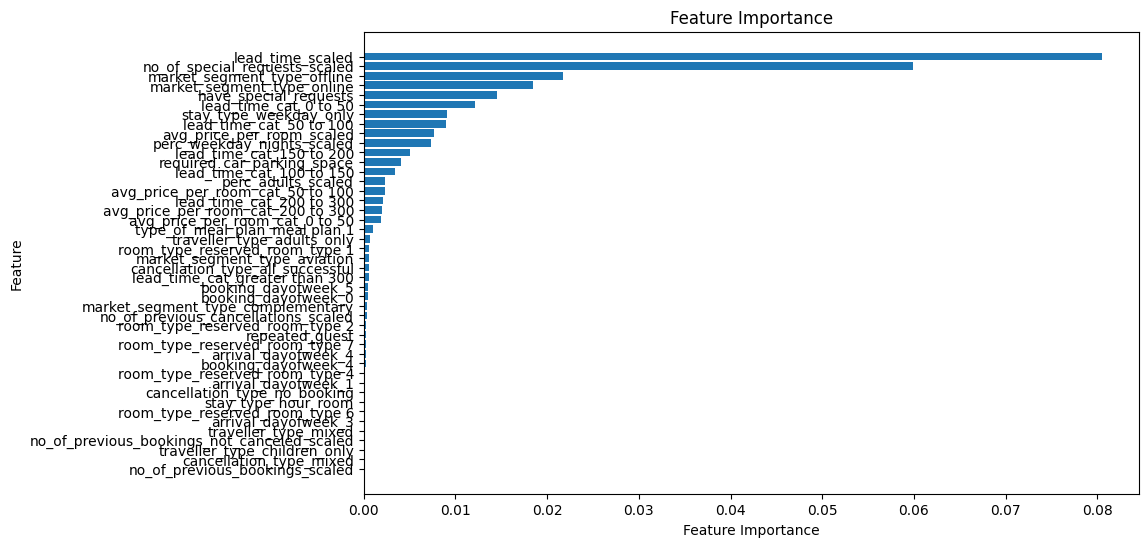

In [9]:
feature_importances, feature_names = compute_permutation_importance(lr, X_train, Y_train)

# Remove features with permutation_importance=0
feature_names = feature_names[feature_importances>0]
feature_importances = feature_importances[feature_importances>0]

# Visualize permutation_importance
plot_feature_importance(feature_importances, feature_names)

In [10]:
selected_columns = feature_names

In [11]:
num_columns = X_train[selected_columns].shape[1]
print("Number of selected features:", num_columns)

Number of selected features: 44


### Fit the model again with the newly selected features

In [12]:
lr_selected = LogisticRegression(max_iter=10000, random_state=47).fit(X_train[selected_columns], Y_train.values.ravel())

# Predict the output based on our training and testing dataset
Y_train_pred_selected = lr_selected.predict(X_train[selected_columns])
Y_test_pred_selected = lr_selected.predict(X_test[selected_columns])

train_metrics, test_metrics = evaluate(Y_train, Y_train_pred_selected, Y_test, Y_test_pred_selected, "Eliminate 0 Permutation Impt", train_metrics, test_metrics)

**Training Set Metrics**
Accuracy 	: 0.7952628481757552
Precision 	: 0.7951759976468281
Recall 		: 0.7954099646920361
F1 Score 	: 0.7952929639617553

**Test Set Metrics**
Accuracy 	: 0.8029598825831703
Precision 	: 0.522257053291536
Recall 		: 0.495243757431629
F1 Score 	: 0.508391821788221


This step allows us to reduce the dimensionality of the feature space, enhancing computational efficiency and potentially mitigating overfitting concerns, while maintaining model performance.

Next, we perform the 4 feature selection methods, as stated above, to choose the best method that would give us the best model performance.

### 1. Forward selection using SequentialFeatureSelector from sklearn

In [13]:
# Initialize a Logistic Regression classifier
lr = LogisticRegression(max_iter=10000, random_state=47)

# Initialize SequentialFeatureSelector with scoring='f1'
sfs_forward = SequentialFeatureSelector(lr, n_features_to_select='auto', direction='forward', scoring='f1', cv=5)

# Fit the SequentialFeatureSelector to the training data
sfs_forward.fit(X_train[selected_columns], Y_train.values.ravel())

# Get the selected features
selected_features_forward = X_train[selected_columns].columns[sfs_forward.get_support()]

# Train the final model using the selected features on the training set
lr_forward = lr.fit(X_train[selected_features_forward], Y_train.values.ravel())

# Predict the output based on the training and testing datasets
Y_train_pred_forward = lr_forward.predict(X_train[selected_features_forward])
Y_test_pred_forward = lr_forward.predict(X_test[selected_features_forward])

train_metrics, test_metrics = evaluate(Y_train, Y_train_pred_forward, Y_test, Y_test_pred_forward, "Forward Feature Selection", train_metrics, test_metrics)

**Training Set Metrics**
Accuracy 	: 0.793252255786583
Precision 	: 0.7974532431356944
Recall 		: 0.7861906630051
F1 Score 	: 0.7917819043856184

**Test Set Metrics**
Accuracy 	: 0.8038160469667319
Precision 	: 0.5240147783251231
Recall 		: 0.5059453032104637
F1 Score 	: 0.514821536600121


### 2. Backward elimination using SequentialFeatureSelector from sklearn

In [14]:
# Initialize a Logistic Regression classifier
lr = LogisticRegression(max_iter=10000, random_state=47)

# Initialize SequentialFeatureSelector with scoring='f1'
sfs_backward = SequentialFeatureSelector(lr, n_features_to_select='auto', direction='backward', scoring='f1', cv=5)

# Fit the SequentialFeatureSelector to the training data
sfs_backward.fit(X_train[selected_columns], Y_train.values.ravel())

# Get the selected features
selected_features_backward = X_train[selected_columns].columns[sfs_backward.get_support()]

# Train the final model using the selected features on the training set
lr_backward = lr.fit(X_train[selected_features_backward], Y_train.values.ravel())

# Predict the output based on the training and testing datasets
Y_train_pred_backward = lr_backward.predict(X_train[selected_features_backward])
Y_test_pred_backward = lr_backward.predict(X_test[selected_features_backward])

train_metrics, test_metrics = evaluate(Y_train, Y_train_pred_backward, Y_test, Y_test_pred_backward, "Backward Feature Selection", train_metrics, test_metrics)

**Training Set Metrics**
Accuracy 	: 0.7934484111416241
Precision 	: 0.7941986234021632
Recall 		: 0.7921734013338564
F1 Score 	: 0.7931847196307571

**Test Set Metrics**
Accuracy 	: 0.8069960861056752
Precision 	: 0.5324594257178527
Recall 		: 0.5071343638525565
F1 Score 	: 0.5194884287454324


### 3. Recursive Feature Elimination with cross validation

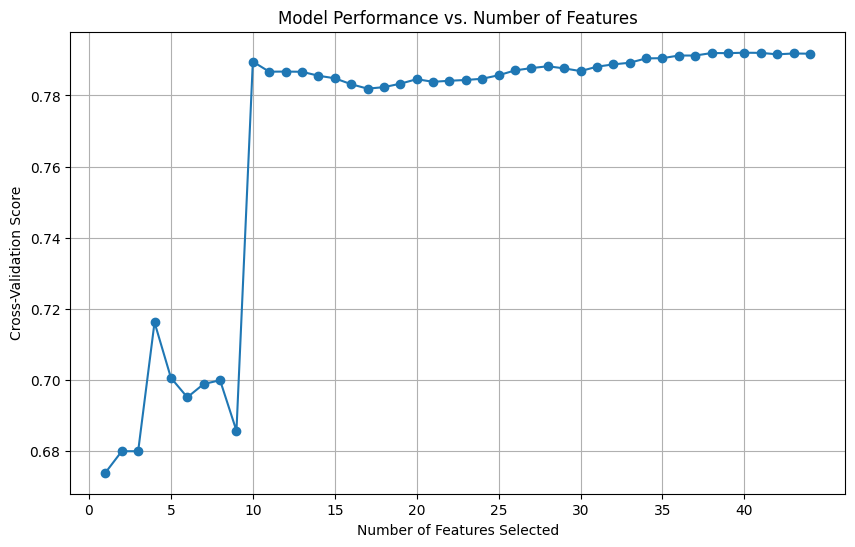

Optimal number of features based on F1 Score: 40


In [15]:
# Instantiate the Logistic Regression classifier
lr = LogisticRegression(max_iter=1000, random_state = 47)

# Call the feature_selection_using_rfecv_on_f1score function
df_features = feature_selection_using_rfecv_on_f1score(lr, X_train[selected_columns], Y_train)

In [16]:
# Filter the selected features based on RFECV results
selected_features = df_features[df_features['selected']]['feature'][:40]

# Select only the selected features from the training and testing datasets
X_train_rfecv = X_train[selected_features]
X_test_rfecv = X_test[selected_features]

# Initialize the logistic regression model
lr = LogisticRegression(max_iter=1000, random_state=47)

# Train the model using the selected features
lr.fit(X_train_rfecv, Y_train.values.ravel())

# Predict the target variable on the test set
Y_train_pred_rfecv = lr.predict(X_train_rfecv)
Y_test_pred_rfecv = lr.predict(X_test_rfecv)

train_metrics, test_metrics = evaluate(Y_train, Y_train_pred_rfecv, Y_test, Y_test_pred_rfecv, "RFECV", train_metrics, test_metrics)

**Training Set Metrics**
Accuracy 	: 0.7958022754021185
Precision 	: 0.7957442635810943
Recall 		: 0.795900353079639
F1 Score 	: 0.7958223006766696

**Test Set Metrics**
Accuracy 	: 0.8028375733855186
Precision 	: 0.5219298245614035
Recall 		: 0.495243757431629
F1 Score 	: 0.5082367297132397


### 4. Univariate Feature Selection

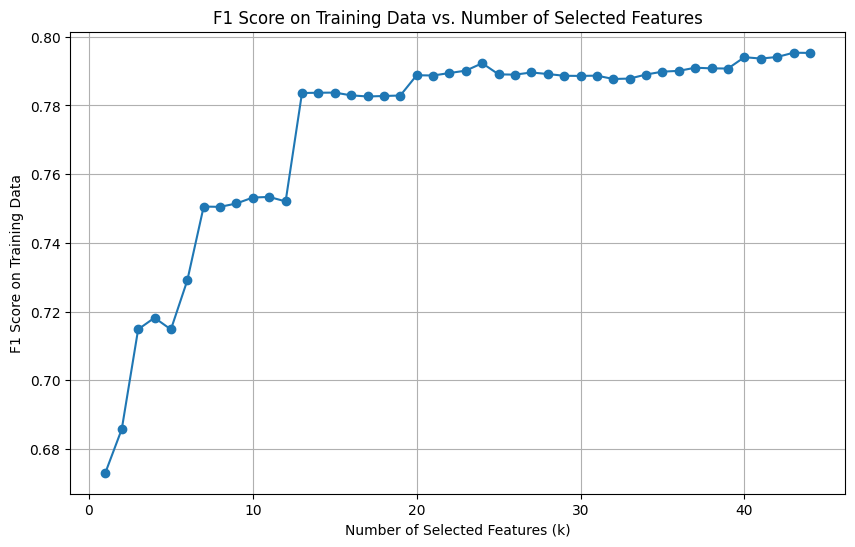

In [17]:
# Initialize LR classifier
lr = LogisticRegression(max_iter=1000, random_state=47)

# Initialize SelectKBest with f_classif scoring function
selector = SelectKBest(score_func=f_classif)

# Lists to store F1 scores and number of selected features
train_f1_scores = []
num_features_selected = []

# Iterate over different values of k
for k in range(1, X_train[selected_columns].shape[1] + 1):
    # Fit selector to training data with k features
    selector.set_params(k=k)
    X_train_selected = selector.fit_transform(X_train[selected_columns], Y_train.values.ravel())
    
    # Train LR classifier on selected features
    lr.fit(X_train_selected, Y_train.values.ravel())
    
    # Make predictions on the training data
    Y_train_pred = lr.predict(X_train_selected)
    
    # Calculate F1 score on the training data
    train_f1 = f1_score(Y_train, Y_train_pred)
    
    # Append F1 score and number of selected features to lists
    train_f1_scores.append(train_f1)
    num_features_selected.append(k)

# Plot F1 score vs. number of selected features
plt.figure(figsize=(10, 6))
plt.plot(num_features_selected, train_f1_scores, marker='o')
plt.title('F1 Score on Training Data vs. Number of Selected Features')
plt.xlabel('Number of Selected Features (k)')
plt.ylabel('F1 Score on Training Data')
plt.grid(True)
plt.show()

From the above graph, we can observe that while the optimal number of selected features (k) is 43, the difference between the F1 score when 24 features were selected and the optimal F1 score is relatively small. Hence, to prioritize reduction of the dimensionality of the feature space and model complexity, we choose 24 as the number of features to be selected and set k=24.

In [18]:
# Select the best features 
selector_24 = SelectKBest(f_classif, k= 24) 
selector_24.fit(X_train[selected_columns], Y_train.values.ravel()) 
X_train_selected_ufs = selector_24.transform(X_train[selected_columns]) 
X_test_selected_ufs = selector_24.transform(X_test[selected_columns]) 

In [19]:
features_ufs_indices = selector_24.get_support(indices=True)
features_ufs = X_train.columns[features_ufs_indices]
features_ufs

Index(['traveller_type_adults_only', 'traveller_type_children_only',
       'stay_type_hour_room', 'cancellation_type_all_successful',
       'lead_time_cat_200 to 300', 'avg_price_per_room_cat_0 to 50',
       'avg_price_per_room_cat_100 to 150',
       'avg_price_per_room_cat_200 to 300', 'avg_price_per_room_cat_50 to 100',
       'arrival_dayofweek_2', 'arrival_dayofweek_3', 'arrival_dayofweek_4',
       'arrival_dayofweek_5', 'arrival_dayofweek_6', 'booking_dayofweek_2',
       'booking_dayofweek_3', 'booking_dayofweek_5', 'booking_dayofweek_6',
       'have_special_requests', 'arrival_isweekend', 'booking_isweekend',
       'num_of_customers_and_room_type_mismatch', 'no_of_customers_scaled',
       'perc_adults_scaled'],
      dtype='object')

In [20]:
lr_ufs = LogisticRegression(max_iter=1000, random_state=47).fit(X_train_selected_ufs,Y_train.values.ravel())

# Make predictions on the testing data
Y_train_pred_selected_ufs = lr_ufs.predict(X_train_selected_ufs)
Y_test_pred_selected_ufs = lr_ufs.predict(X_test_selected_ufs)

train_metrics, test_metrics = evaluate(Y_train, Y_train_pred_selected_ufs, Y_test, Y_test_pred_selected_ufs, "Univariate Feature Selection", train_metrics, test_metrics)

**Training Set Metrics**
Accuracy 	: 0.7933993723028638
Precision 	: 0.7965698423713691
Recall 		: 0.7880541388779914
F1 Score 	: 0.792289109106148

**Test Set Metrics**
Accuracy 	: 0.8036937377690803
Precision 	: 0.5250814332247556
Recall 		: 0.47919143876337694
F1 Score 	: 0.5010879701585328


In [21]:
test_metrics

,Classification Model,Accuracy,Precision,Recall,F1 Score
0,Before Feature Engineering,0.813478,0.559878,0.436385,0.490478
1,After Feature Engineering,0.802226,0.520174,0.498216,0.508958
2,Eliminate 0 Permutation Impt,0.802960,0.522257,0.495244,0.508392
3,Forward Feature Selection,0.803816,0.524015,0.505945,0.514822
4,Backward Feature Selection,0.806996,0.532459,0.507134,0.519488
5,RFECV,0.802838,0.521930,0.495244,0.508237
6,Univariate Feature Selection,0.803694,0.525081,0.479191,0.501088


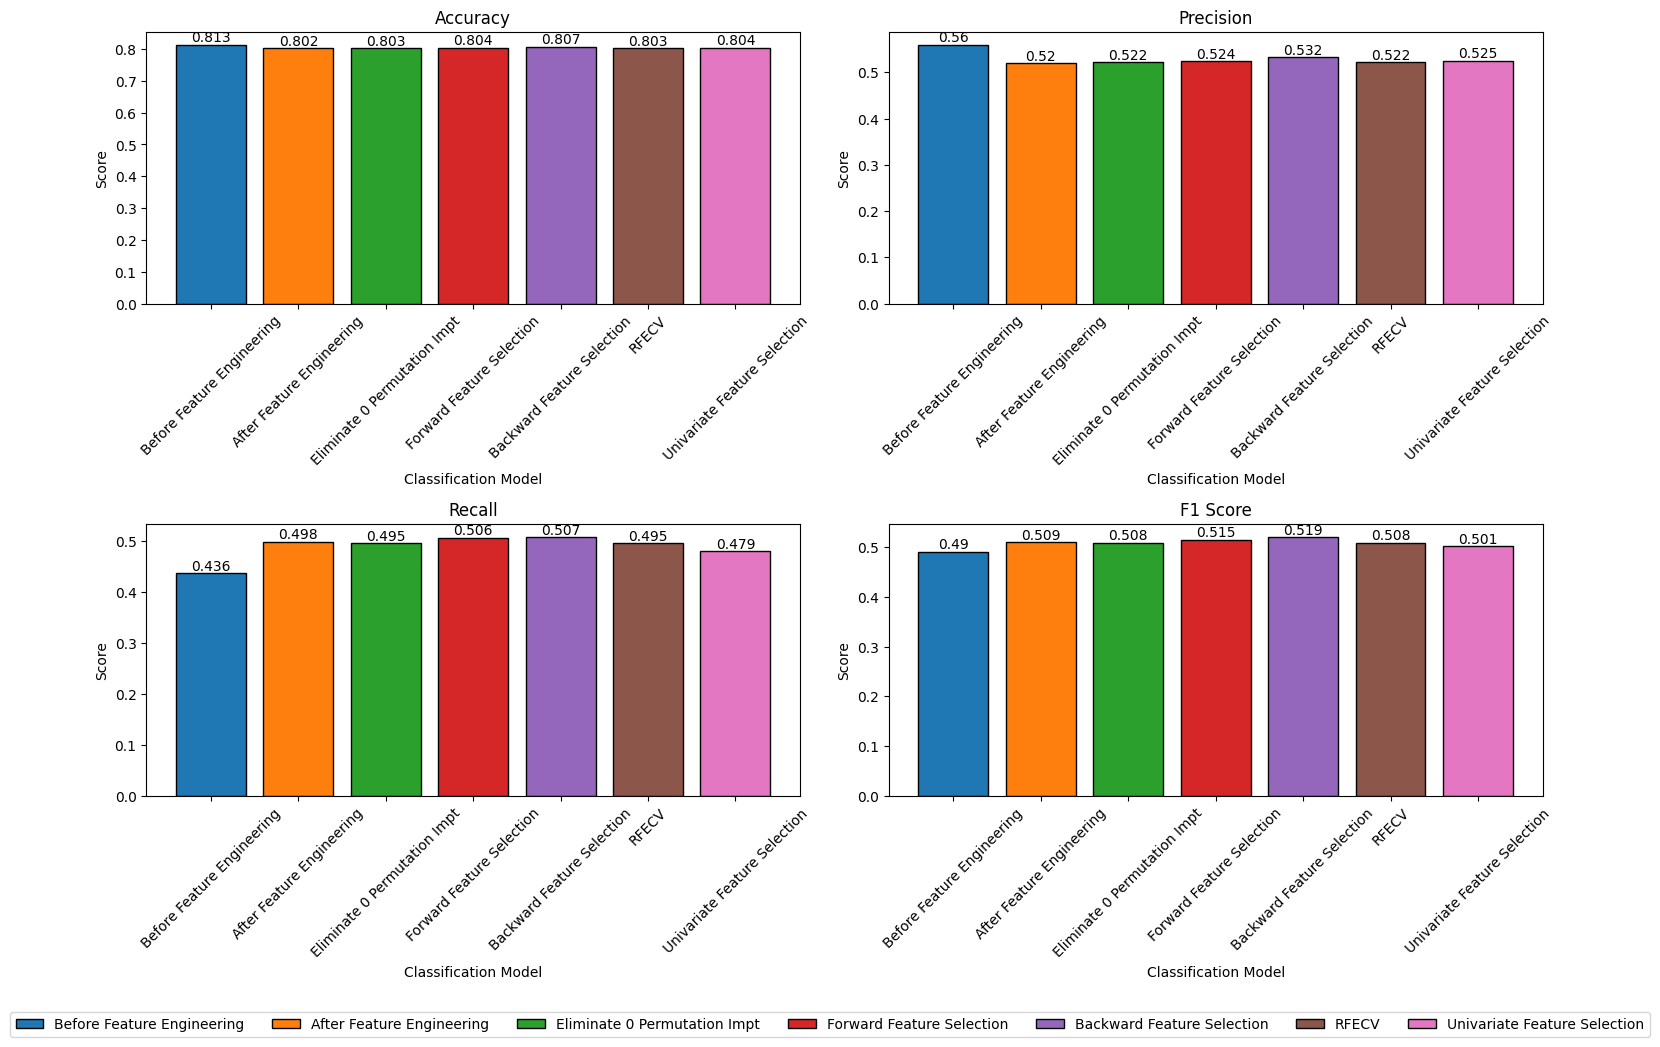

In [22]:
plotMetricsGraphComparison(test_metrics)

Comparing the results of the 4 feature selection methods, we observe that the backward elimination method improved the model performance the best. Therefore, we would proceed with the feature set obtained after performing backward feature elimination.

Let us now take a look at the details of the selected features.

In [23]:
num_features = len(selected_features_backward)
print("Number of selected features:", num_features)

Number of selected features: 22


In [24]:
print("Selected Features:", selected_features_backward)

Selected Features: Index(['arrival_dayofweek_3', 'cancellation_type_no_booking',
       'room_type_reserved_room_type 7', 'no_of_previous_cancellations_scaled',
       'booking_dayofweek_0', 'booking_dayofweek_5',
       'lead_time_cat_greater than 300', 'type_of_meal_plan_meal plan 1',
       'avg_price_per_room_cat_0 to 50', 'avg_price_per_room_cat_200 to 300',
       'lead_time_cat_200 to 300', 'avg_price_per_room_cat_50 to 100',
       'lead_time_cat_100 to 150', 'required_car_parking_space',
       'perc_weekday_nights_scaled', 'avg_price_per_room_scaled',
       'lead_time_cat_50 to 100', 'have_special_requests',
       'market_segment_type_online', 'market_segment_type_offline',
       'no_of_special_requests_scaled', 'lead_time_scaled'],
      dtype='object')


## Hyperparameter Tuning 
The main hyperparameters we may tune in logistic regression are: 
1. solver: the algorithm to use in the optimization problem
2. penalty: intends to reduce model generalization error, and is meant to disincentivize and regulate overfitting
3. regularization strength: works with the penalty to regulate overfitting (Smaller values specify stronger regularization and high value tells the model to give high weight to the training data.)

In [25]:
# Define the hyperparameters to tune
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],  # Regularization parameter
    'penalty': ['l1', 'l2'],  # Regularization penalty
    'solver': ['liblinear', 'saga']  # Optimization algorithm
}


# Create a logistic regression model
logistic_model = LogisticRegression(max_iter=10000)

# Perform grid search cross-validation
grid_search = GridSearchCV(estimator=logistic_model, param_grid=param_grid, cv=5, scoring='f1', verbose=2, n_jobs=-1)

# Fit GridSearchCV on training data
grid_search.fit(X_train[selected_features_backward], Y_train.values.ravel())

# Get the best hyperparameters
best_params = grid_search.best_params_
print("Best hyperparameters:", best_params)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best hyperparameters: {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}


## Fit the model again with the tuned parameters

In [26]:
# Create a logistic regression model with the best hyperparameters
best_lr_model = LogisticRegression(max_iter=10000, C=0.1, penalty='l2', solver='liblinear', random_state = 47)

# Fit the logistic regression model to the training data
best_lr_model.fit(X_train[selected_features_backward], Y_train.values.ravel())

LogisticRegression(C=0.1, max_iter=10000, random_state=47, solver='liblinear')

In [27]:
# Make predictions on the testing data
Y_train_pred_tuned = best_lr_model.predict(X_train[selected_features_backward])
Y_test_pred_tuned = best_lr_model.predict(X_test[selected_features_backward])

train_metrics, test_metrics = evaluate(Y_train, Y_train_pred_tuned, Y_test, Y_test_pred_tuned, "After Hyperparameter Tuning", train_metrics, test_metrics)

**Training Set Metrics**
Accuracy 	: 0.7952138093369949
Precision 	: 0.7976072770417243
Recall 		: 0.7911926245586505
F1 Score 	: 0.7943870014771048

**Test Set Metrics**
Accuracy 	: 0.8094422700587084
Precision 	: 0.5390920554854981
Recall 		: 0.5083234244946492
F1 Score 	: 0.5232558139534884


In [28]:
test_metrics

,Classification Model,Accuracy,Precision,Recall,F1 Score
0,Before Feature Engineering,0.813478,0.559878,0.436385,0.490478
1,After Feature Engineering,0.802226,0.520174,0.498216,0.508958
2,Eliminate 0 Permutation Impt,0.802960,0.522257,0.495244,0.508392
3,Forward Feature Selection,0.803816,0.524015,0.505945,0.514822
4,Backward Feature Selection,0.806996,0.532459,0.507134,0.519488
5,RFECV,0.802838,0.521930,0.495244,0.508237
6,Univariate Feature Selection,0.803694,0.525081,0.479191,0.501088
7,After Hyperparameter Tuning,0.809442,0.539092,0.508323,0.523256


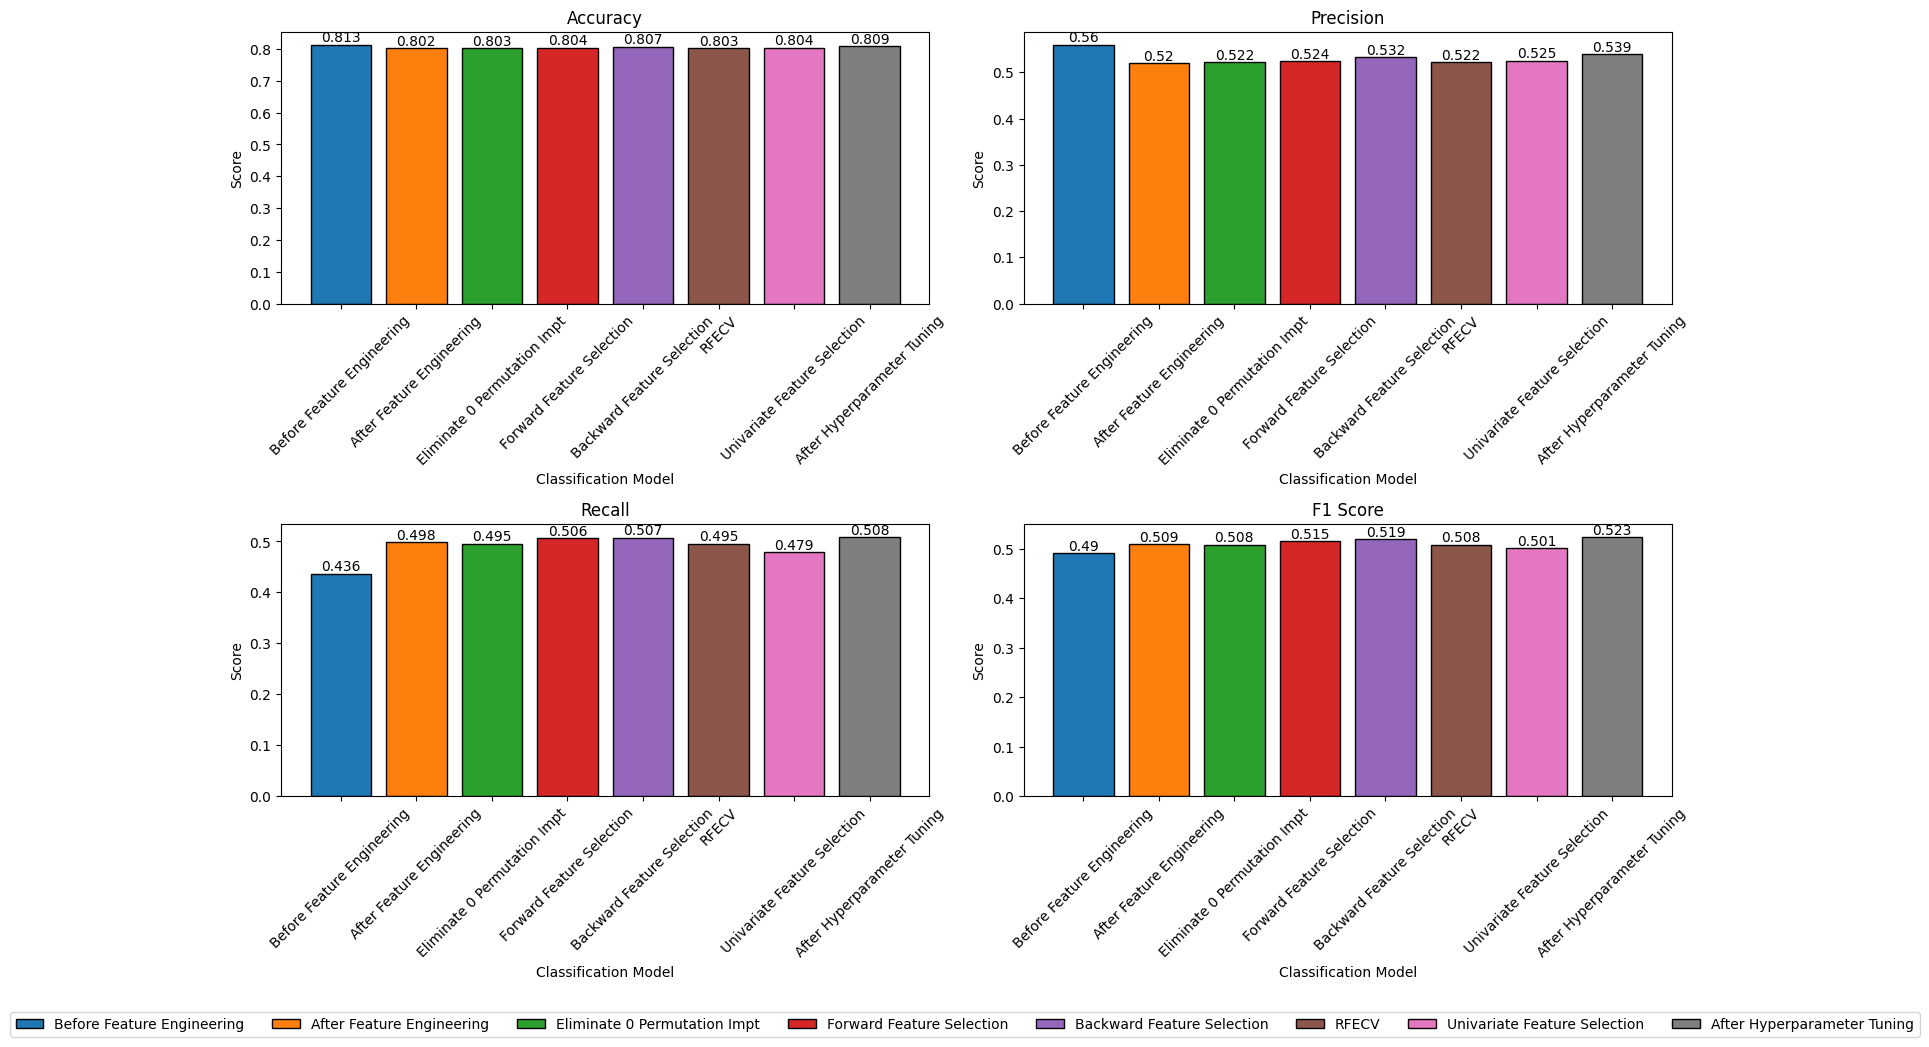

In [29]:
plotMetricsGraphComparison(test_metrics)

## Export Best Model

In [30]:
# Exporting the features used for this model
from FeatureSelectionUtils import export_final_selected_features_to_csv

export_final_selected_features_to_csv(selected_features_backward, "Best Logistic Regression")

Features exported successfully to FinalModels/Feature_Selection/Best Logistic Regression


In [31]:
# export the best model to be compared later on
import joblib

lr_final = LogisticRegression(max_iter=10000, C=0.1, penalty='l2', solver='liblinear', random_state = 47).fit(X_train[selected_features_backward], Y_train.values.ravel())

joblib.dump(lr_final, "FinalModels/BestLogisticRegression.pkl")

['FinalModels/BestLogisticRegression.pkl']

## Next Steps

Now, after doing feature selection and hyperparameter tuning, the model is exported out such that we can compare this classification model (logistic regression) with the best feature selection and hyperparameter tuning to other best classification models later.


## To Navigate To The Next Notebook:
0. [Introduction](/0%20-%20Introduction.ipynb) 
1. [Data Cleaning Notebook](/1%20-%20Data%20Cleaning.ipynb) 
2. [Exploratory Data Analyis Notebook](/2%20-%20Data%20Exploration.ipynb)
3. [Data Pre-processing Notebook](/3%20-%20Data%20Pre-Processing.ipynb)
4. [Initial Classification Models Notebook](/4%20-%20ClassificationModels.ipynb)
5. [Feature Engineering Notebook](/5%20-%20Feature%20Engineering.ipynb) 
6. Applying Feature Selection + Hyperparameter Tuning On Individual Models
   1. [Logistic Regression Notebook](/6.1%20-%20Logistic%20Regression.ipynb) - <b>[You Are Here Now]</b>
   2. [K Nearest Neighbour Notebook](/6.2%20-%20K%20Nearest%20Neighbour.ipynb)
   3. [Decision Tree Notebook](/6.3%20-%20Decision%20Tree.ipynb)
   4. [Support Vector Machine Notebook](/6.4%20-%20SVM.ipynb)
   5. [Random Forest Notebook](/6.5%20-%20Random%20Forest.ipynb)
   6. [Adaboost Notebook](/6.6%20-%20Adaboost.ipynb)
   7. [Gradient Boost Notebook](/6.7%20-%20Gradient%20Boosting.ipynb)
   8. [LightGBM Notebook](/6.8%20-%20LightGBM.ipynb)
7.  [Final Model Comparisons + Conclusion Notebook](/7%20-%20Model%20Comparison,%20Final%20Model%20and%20Conclusion.ipynb)